## Setup Packages

In [227]:
import warnings
warnings.filterwarnings('ignore')

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
# import pandasql as ps
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Load Dataset

In [228]:
df = pd.read_csv("flight.csv")

df.head()

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,54993,11/2/2006,12/24/2008,Male,6,.,beijing,CN,31.0,3/31/2014,...,234188.0,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50
1,28065,2/19/2007,8/3/2007,Male,6,NaN,beijing,CN,42.0,3/31/2014,...,167434.0,293678,3/25/2014,7,5.194245,17,29,1.252314,415768,33
2,55106,2/1/2007,8/30/2007,Male,6,.,beijing,CN,40.0,3/31/2014,...,164982.0,283712,3/21/2014,11,5.298507,18,20,1.254676,406361,26
3,21189,8/22/2008,8/23/2008,Male,5,Los Angeles,CA,US,64.0,3/31/2014,...,125500.0,281336,12/26/2013,97,27.863636,73,11,1.090870,372204,12
4,39546,4/10/2009,4/15/2009,Male,6,guiyang,guizhou,CN,48.0,3/31/2014,...,130702.0,309928,3/27/2014,5,4.788079,47,27,0.970658,338813,39


### Data Understanding

- MEMBER_NO = Customer ID
- FFP_DATE = Frequent Flyer Program Join Date
- FIRST_FLIGHT_DATE = First Flight
- Gender = male and female
- FFP_TIER = Frequent Flyer Program class
- WORK_CITY = Customer Workplace
- WORK_PROVINCE = Customer Workplace
- WORK_COUNTRY = Customer Workplace
- AGE = Customer Age
- LOAD_TIME = Date the data taken.
- FLIGHT_COUNT = sum of customer flight
- BP_SUM = Flight Plan
- SUM_YR 1 = Fare Revenue
- SUM_YR 2 = Votes Prices
- SEG_KM_SUM = total filght distance
- LAST_FLIGHT_DATE = last flight
- LAST_TO_END = the distace between last book and last flight
- AVG_INTERVAL = average time interval
- MAX_INTERVAL = maximum time interval
- EXCHANGE_COUNT = total money exchange
- avg_discount = average of the discount that customer get
- Points_Sum = Total customer point
- Point_NotFlight = Unused point

In [229]:
print(df.shape)

(62988, 23)


In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MEMBER_NO          62988 non-null  int64  
 1   FFP_DATE           62988 non-null  object 
 2   FIRST_FLIGHT_DATE  62988 non-null  object 
 3   GENDER             62985 non-null  object 
 4   FFP_TIER           62988 non-null  int64  
 5   WORK_CITY          60719 non-null  object 
 6   WORK_PROVINCE      59740 non-null  object 
 7   WORK_COUNTRY       62962 non-null  object 
 8   AGE                62568 non-null  float64
 9   LOAD_TIME          62988 non-null  object 
 10  FLIGHT_COUNT       62988 non-null  int64  
 11  BP_SUM             62988 non-null  int64  
 12  SUM_YR_1           62437 non-null  float64
 13  SUM_YR_2           62850 non-null  float64
 14  SEG_KM_SUM         62988 non-null  int64  
 15  LAST_FLIGHT_DATE   62988 non-null  object 
 16  LAST_TO_END        629

## Data Cleaning

In [231]:
# Check Duplicated
df.duplicated().sum()

0

In [232]:
# Check Missing Values with percentage
missing_value = df.isnull().sum().reset_index()
missing_value.columns = ['feature','missing_value']
missing_value['percentage'] = round((missing_value['missing_value']/len(df))*100,2)
missing_value

,feature,missing_value,percentage
0,MEMBER_NO,0,0.00
1,FFP_DATE,0,0.00
2,FIRST_FLIGHT_DATE,0,0.00
3,GENDER,3,0.00
4,FFP_TIER,0,0.00
5,WORK_CITY,2269,3.60
6,WORK_PROVINCE,3248,5.16
7,WORK_COUNTRY,26,0.04
8,AGE,420,0.67
9,LOAD_TIME,0,0.00


since the missing data is <= 5%. We can drop the data

In [233]:
df = df.dropna()

Since we will not use MEMBER_NO, we'll drop it.

In [234]:
df = df.drop("MEMBER_NO", axis=1)

## Data Split

In [235]:
# Numerical data
numerical = ['int64', 'float64']
df_num = df.select_dtypes(include=numerical)
df_num

,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,6,31.0,210,505308,239560.0,234188.0,580717,1,3.483254,18,34,0.961639,619760,50
2,6,40.0,135,351159,163618.0,164982.0,283712,11,5.298507,18,20,1.254676,406361,26
3,5,64.0,23,337314,116350.0,125500.0,281336,97,27.863636,73,11,1.090870,372204,12
4,6,48.0,152,273844,124560.0,130702.0,309928,5,4.788079,47,27,0.970658,338813,39
5,6,64.0,92,313338,112364.0,76946.0,294585,79,7.043956,52,10,0.967692,343121,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62982,4,35.0,2,0,0.0,0.0,3848,437,0.000000,0,0,0.000000,0,0
62983,4,25.0,2,0,0.0,0.0,1134,297,4.000000,4,1,0.000000,12318,22
62984,4,38.0,4,0,0.0,0.0,8016,89,37.000000,60,14,0.000000,106972,43
62985,4,43.0,2,0,0.0,0.0,2594,29,166.000000,166,0,0.000000,0,0


In [236]:
# categorical data
df_cat = df.select_dtypes(include="object")
df_cat

,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,LOAD_TIME,LAST_FLIGHT_DATE
0,11/2/2006,12/24/2008,Male,.,beijing,CN,3/31/2014,3/31/2014
2,2/1/2007,8/30/2007,Male,.,beijing,CN,3/31/2014,3/21/2014
3,8/22/2008,8/23/2008,Male,Los Angeles,CA,US,3/31/2014,12/26/2013
4,4/10/2009,4/15/2009,Male,guiyang,guizhou,CN,3/31/2014,3/27/2014
5,2/10/2008,9/29/2009,Male,guangzhou,guangdong,CN,3/31/2014,1/13/2014
...,...,...,...,...,...,...,...,...
62982,1/20/2013,1/20/2013,Female,beijing,.,CN,3/31/2014,1/20/2013
62983,5/20/2011,6/5/2013,Female,guangzhou,guangdong,CN,3/31/2014,6/9/2013
62984,3/8/2010,9/14/2013,Male,foshan,guangdong,CN,3/31/2014,1/3/2014
62985,3/30/2006,12/2/2006,Female,guangzhou,guangdong,CN,3/31/2014,3/3/2014


**The dataset consists of 8 categorical columns and 14 numerical columns.**

## EDA (exploratory data analysis)

### Univariate Analysis

In [237]:
df_cat.describe()

,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,LOAD_TIME,LAST_FLIGHT_DATE
count,58255,58255,58255,58255,58255,58255,58255,58255
unique,3062,3399,2,2944,1127,105,1,731
top,1/13/2011,2/16/2013,Male,guangzhou,guangdong,CN,3/31/2014,3/31/2014
freq,179,88,44434,9283,17329,54954,58255,915


**There is 4 Date datatype** and 4 categorical (`GENDER`, `WORK_CITY`, `WORK_PROVINCE`, `WORK_COUNTRY`)

In [238]:
# Workplace Distriburion
WORK_CITY = df['WORK_CITY'].value_counts().reset_index()
WORK_PROVINCE = df['WORK_PROVINCE'].value_counts().reset_index()
WORK_COUNTRY = df['WORK_COUNTRY'].value_counts().reset_index()

# Top 5
WORK_CITY = WORK_CITY[0:5]
WORK_PROVINCE = WORK_PROVINCE[0:5]
WORK_COUNTRY = WORK_COUNTRY[0:5]

In [239]:
# top 5 Work City
WORK_CITY.columns = ['work_city', 'freq']
WORK_CITY['percent'] = round((WORK_CITY['freq']/WORK_CITY['freq'].sum())*100,2)
WORK_CITY

,work_city,freq,percent
0,guangzhou,9283,34.50
1,beijing,7547,28.05
2,shanghai,4611,17.14
3,shenzhen,3551,13.20
4,dalian,1915,7.12


In [240]:
# top 5 Work Province
WORK_PROVINCE.columns = ['work_province', 'freq']
WORK_PROVINCE['percent'] = round((WORK_PROVINCE['freq']/WORK_PROVINCE['freq'].sum())*100,2)
WORK_PROVINCE

,work_province,freq,percent
0,guangdong,17329,47.92
1,beijing,7708,21.32
2,shanghai,4645,12.85
3,liaoning,4048,11.19
4,xinjiang,2431,6.72


In [241]:
# top 5 Work Country
WORK_COUNTRY.columns = ['work_country', 'freq']
WORK_COUNTRY['percent'] = round((WORK_COUNTRY['freq']/WORK_COUNTRY['freq'].sum())*100,2)
WORK_COUNTRY

,work_country,freq,percent
0,CN,54954,96.02
1,KR,715,1.25
2,JP,713,1.25
3,US,476,0.83
4,HK,371,0.65


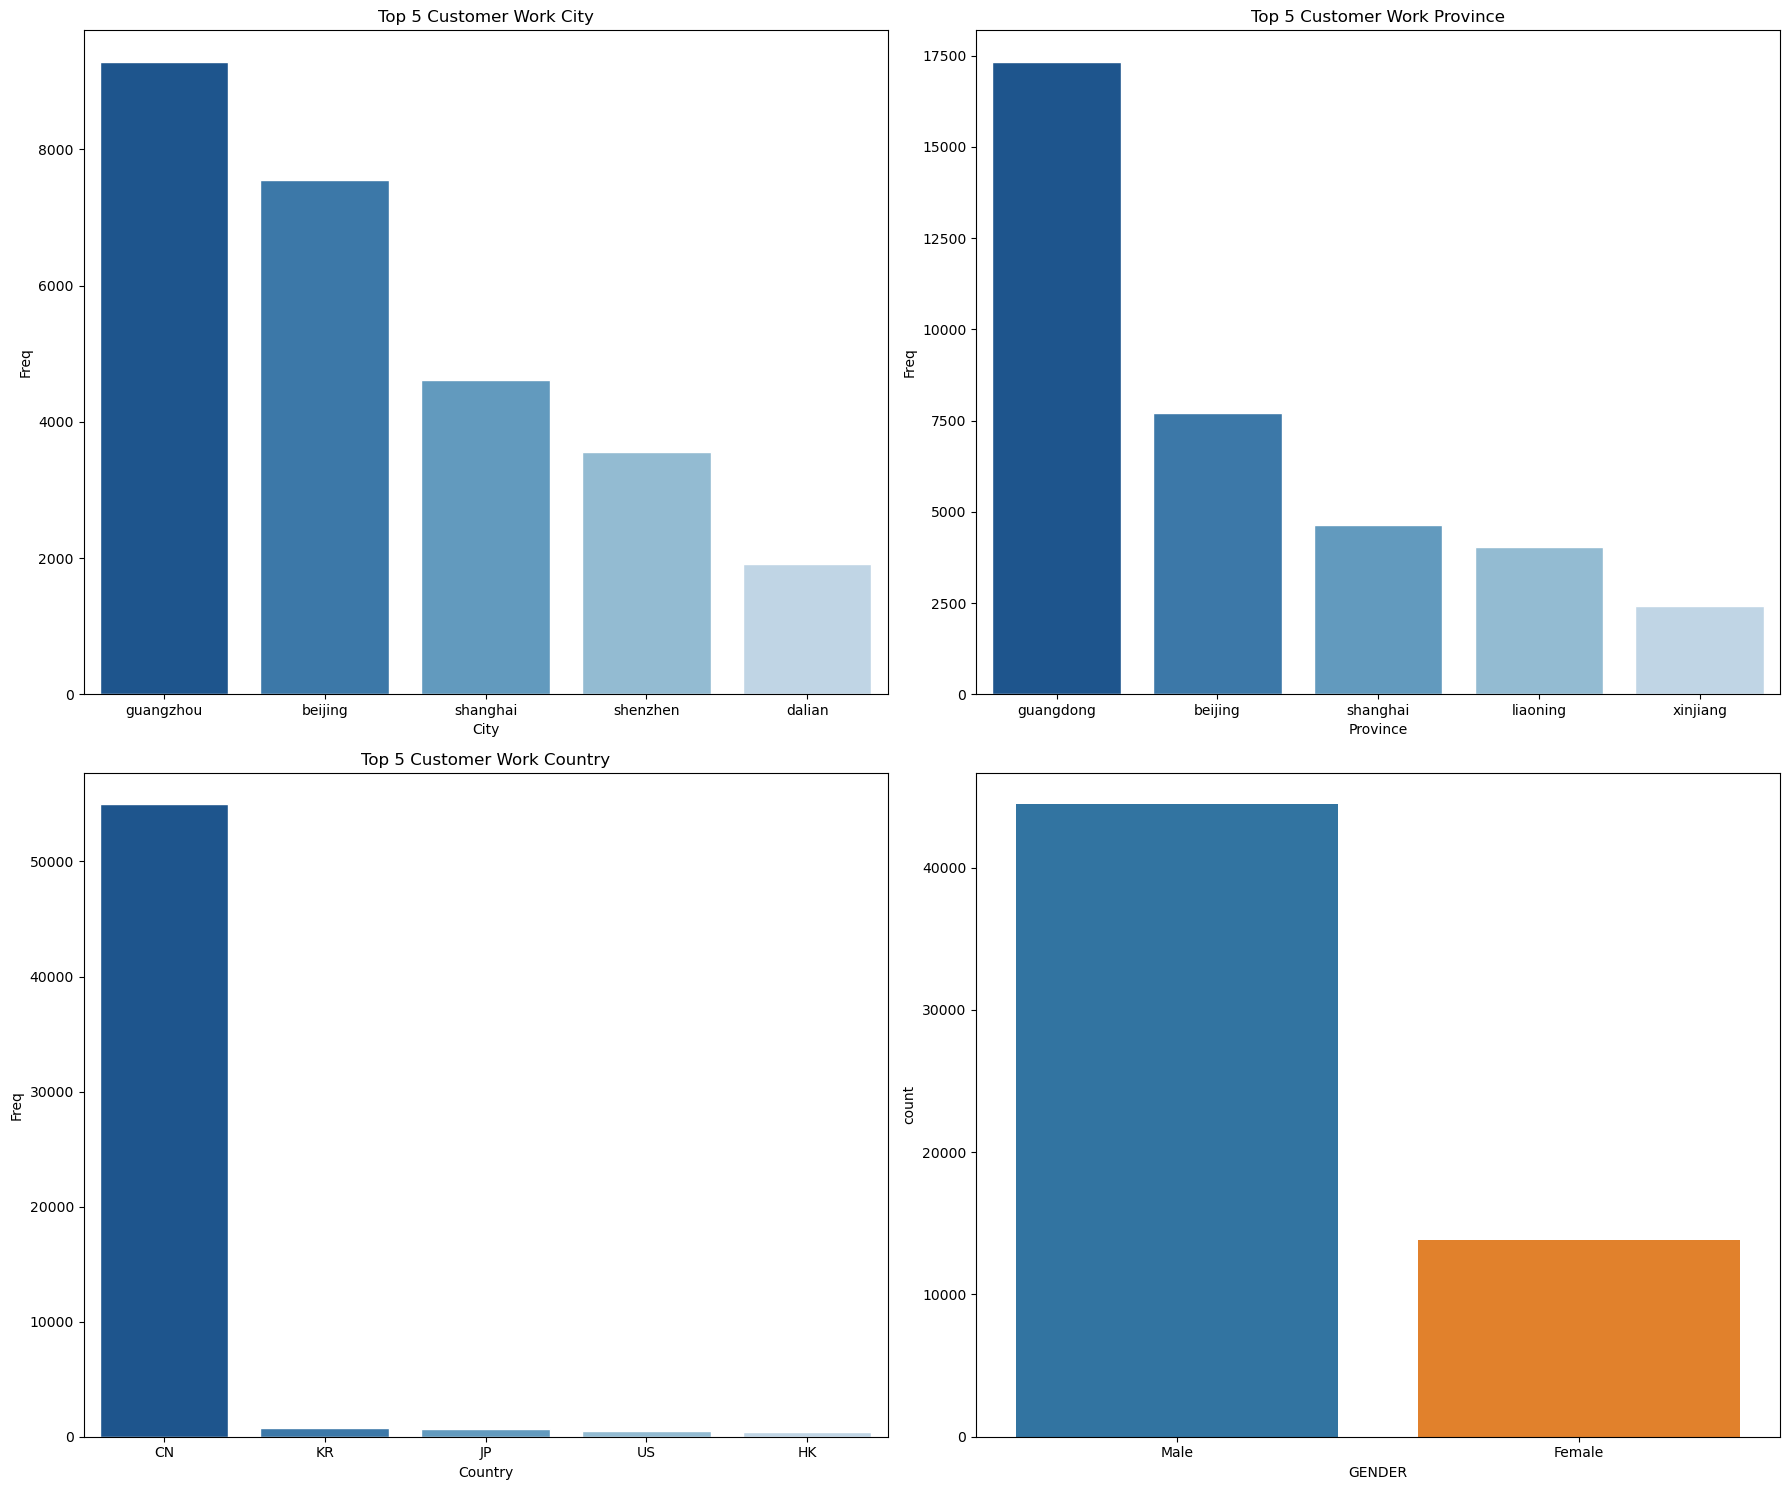

In [242]:
# Visualize the Data
fig,axs = plt.subplots(2,2,figsize=(18,15))

sns.barplot(x='work_city', y='freq', data=WORK_CITY, edgecolor='white', ax=axs[0,0], palette=sns.color_palette("Blues")[::-1])
axs[0,0].set_title('Top 5 Customer Work City')
axs[0,0].set_xlabel('City')
axs[0,0].set_ylabel('Freq')

sns.barplot(x='work_province', y='freq', data=WORK_PROVINCE, edgecolor='white', ax=axs[0,1], palette=sns.color_palette("Blues")[::-1])
axs[0,1].set_title('Top 5 Customer Work Province')
axs[0,1].set_xlabel('Province')
axs[0,1].set_ylabel('Freq')

sns.barplot(x='work_country', y='freq', data=WORK_COUNTRY, edgecolor='white', ax=axs[1,0], palette=sns.color_palette("Blues")[::-1])
axs[1,0].set_title('Top 5 Customer Work Country')
axs[1,0].set_xlabel('Country')
axs[1,0].set_ylabel('Freq')

sns.countplot(df_cat, x="GENDER", hue="GENDER", ax=axs[1,1])

plt.tight_layout()

In [243]:
df_num.describe()

,FFP_TIER,AGE,FLIGHT_COUNT,BP_SUM,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
count,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000,58255.000000
mean,4.104849,42.228736,12.067634,11066.303682,5366.827963,5694.530650,17353.000910,171.255309,67.937285,167.349206,0.328384,0.720627,12742.648820,2.820548
std,0.378182,9.761965,14.236472,16283.209178,8103.595049,8710.724917,20969.886756,180.560120,77.449058,122.890446,1.148485,0.183895,20606.104272,7.500252
min,4.000000,6.000000,2.000000,0.000000,0.000000,0.000000,368.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,35.000000,3.000000,2608.000000,1016.000000,846.000000,4904.000000,28.000000,23.700000,81.000000,0.000000,0.612155,2872.500000,0.000000
50%,4.000000,41.000000,7.000000,5832.000000,2808.000000,2846.000000,10237.000000,104.000000,44.833333,144.000000,0.000000,0.711468,6487.000000,0.000000
75%,4.000000,48.000000,15.000000,13022.000000,6591.500000,6958.000000,21571.500000,258.000000,82.000000,228.000000,0.000000,0.808159,14527.000000,1.000000
max,6.000000,110.000000,213.000000,505308.000000,239560.000000,234188.000000,580717.000000,731.000000,728.000000,728.000000,46.000000,1.500000,985572.000000,140.000000


We will visualize the distribution of :
- Age
- Flight Count
- Total Distance
- Average Discount

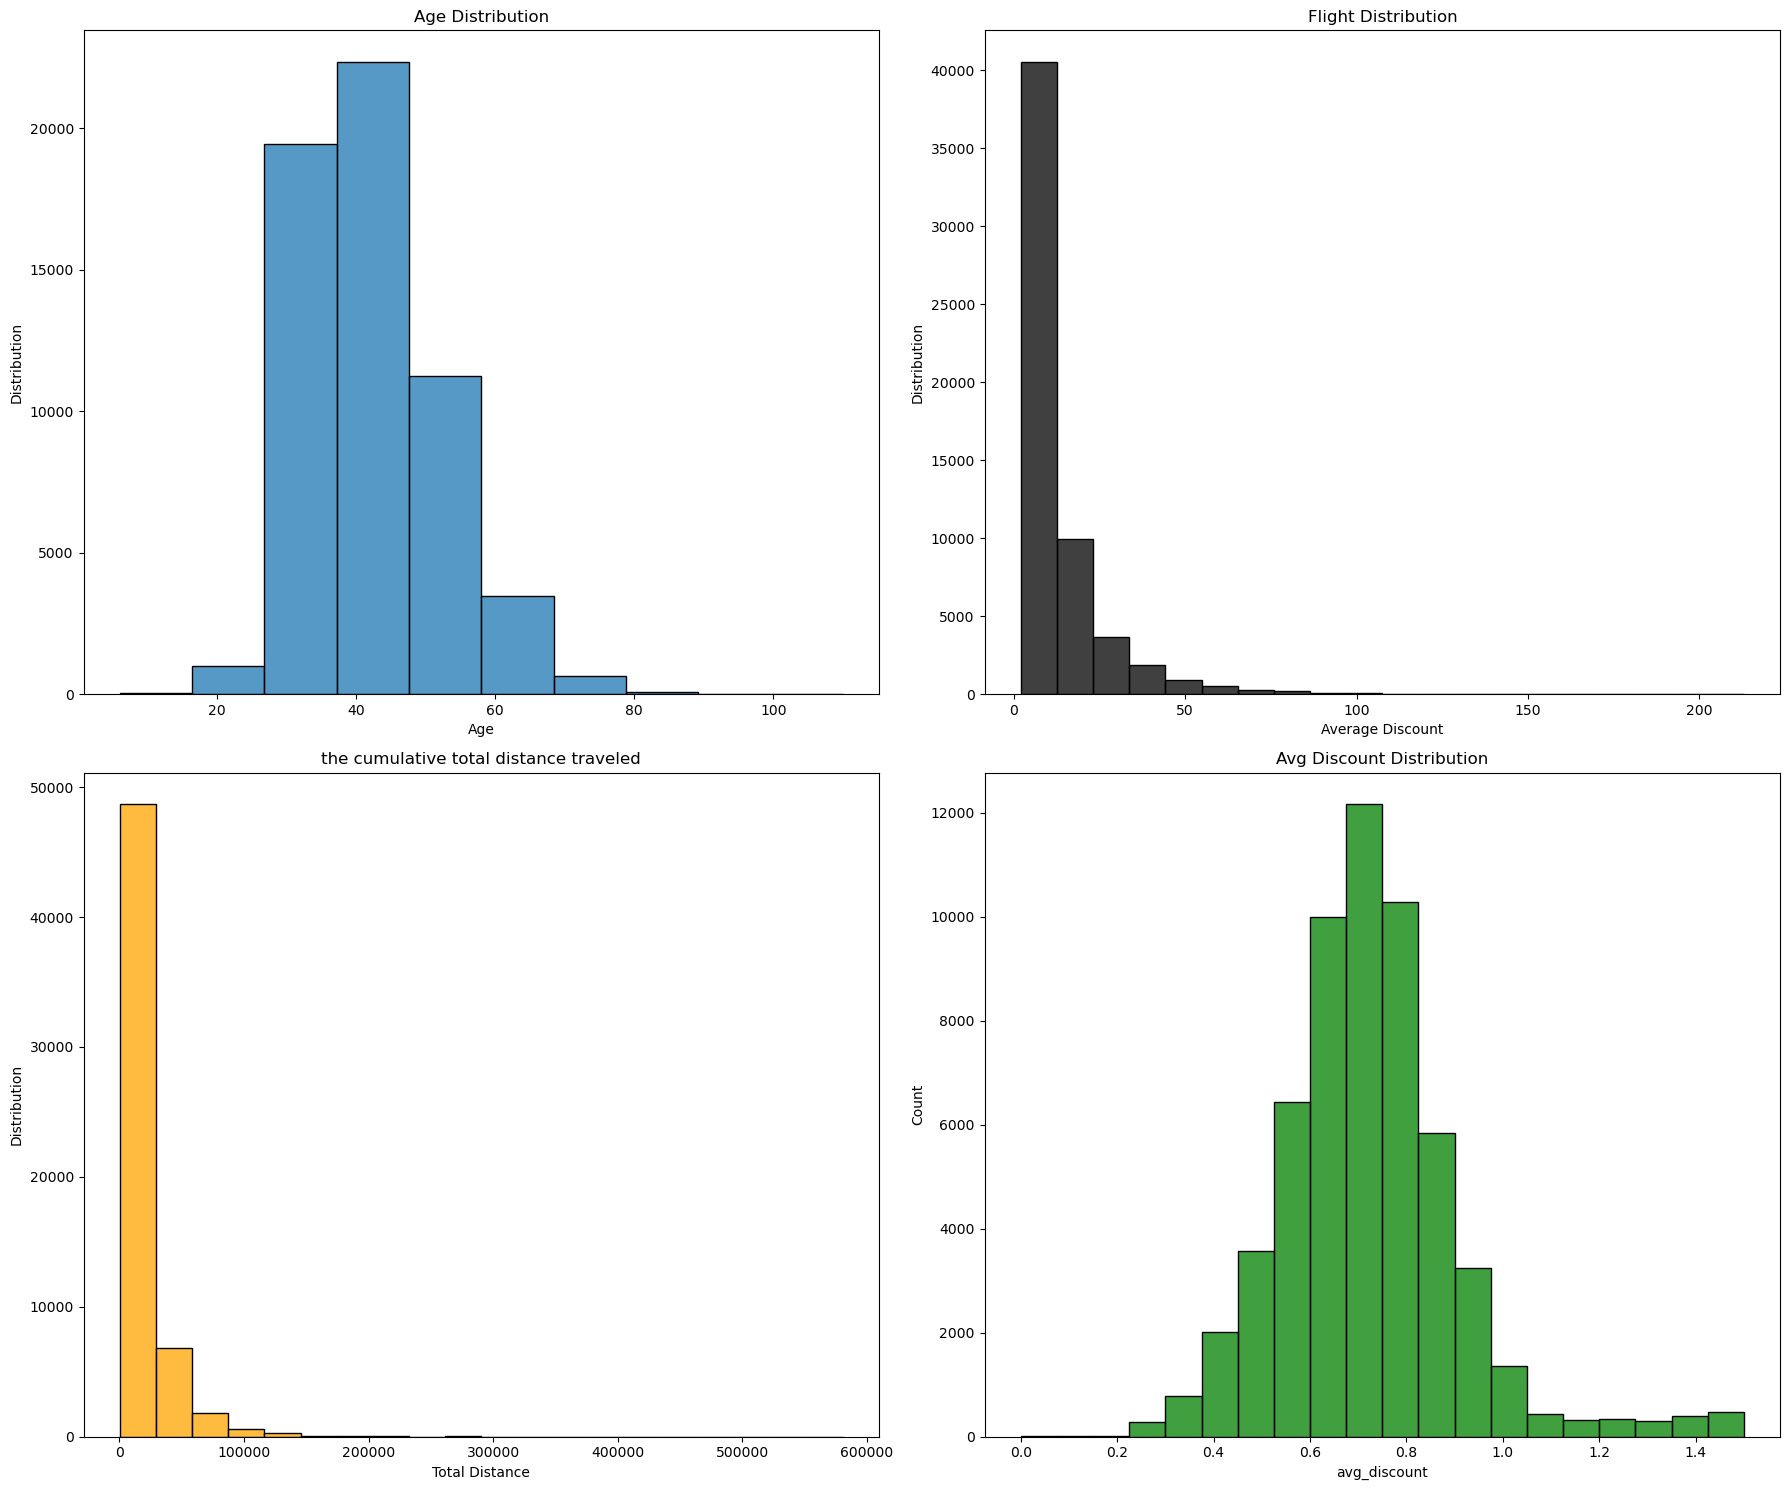

In [244]:
# Data Distribution
fig,axs = plt.subplots(2,2,figsize=(18,15))

sns.histplot(df_num['AGE'], bins=10, ax=axs[0,0])
axs[0,0].set_title('Age Distribution')
axs[0,0].set_xlabel('Age')
axs[0,0].set_ylabel('Distribution')

sns.histplot(df_num['FLIGHT_COUNT'], bins=20, ax=axs[0,1], color="black")
axs[0,1].set_title('Flight Distribution')
axs[0,1].set_xlabel('Flight Count')
axs[0,1].set_ylabel('Distribution')

sns.histplot(df_num['SEG_KM_SUM'],bins=20, ax=axs[1,0], color="orange")
axs[1,0].set_title('the cumulative total distance traveled')
axs[1,0].set_xlabel('Total Distance')
axs[1,0].set_ylabel('Distribution')

sns.histplot(df_num['avg_discount'],bins=20, ax=axs[1,1], color="green")
axs[1,1].set_title('Avg Discount Distribution')
axs[0,1].set_xlabel('Average Discount')
axs[0,1].set_ylabel('Distribution')

plt.tight_layout()

We have 3 left-skewed distribution (age, flight count and travel distance)
and 1 normal distribution (discount)

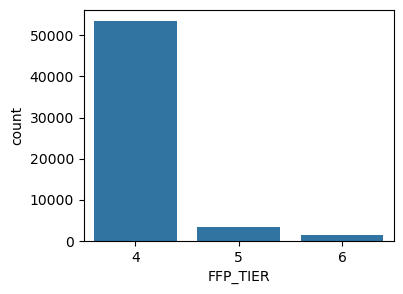

In [277]:
plt.figure(figsize=(4,3))
ax = sns.countplot(x=df_num["FFP_TIER"])

We got Tier 4 as the favorite Tier

### Numerik Multivariat Analysis

<Axes: >

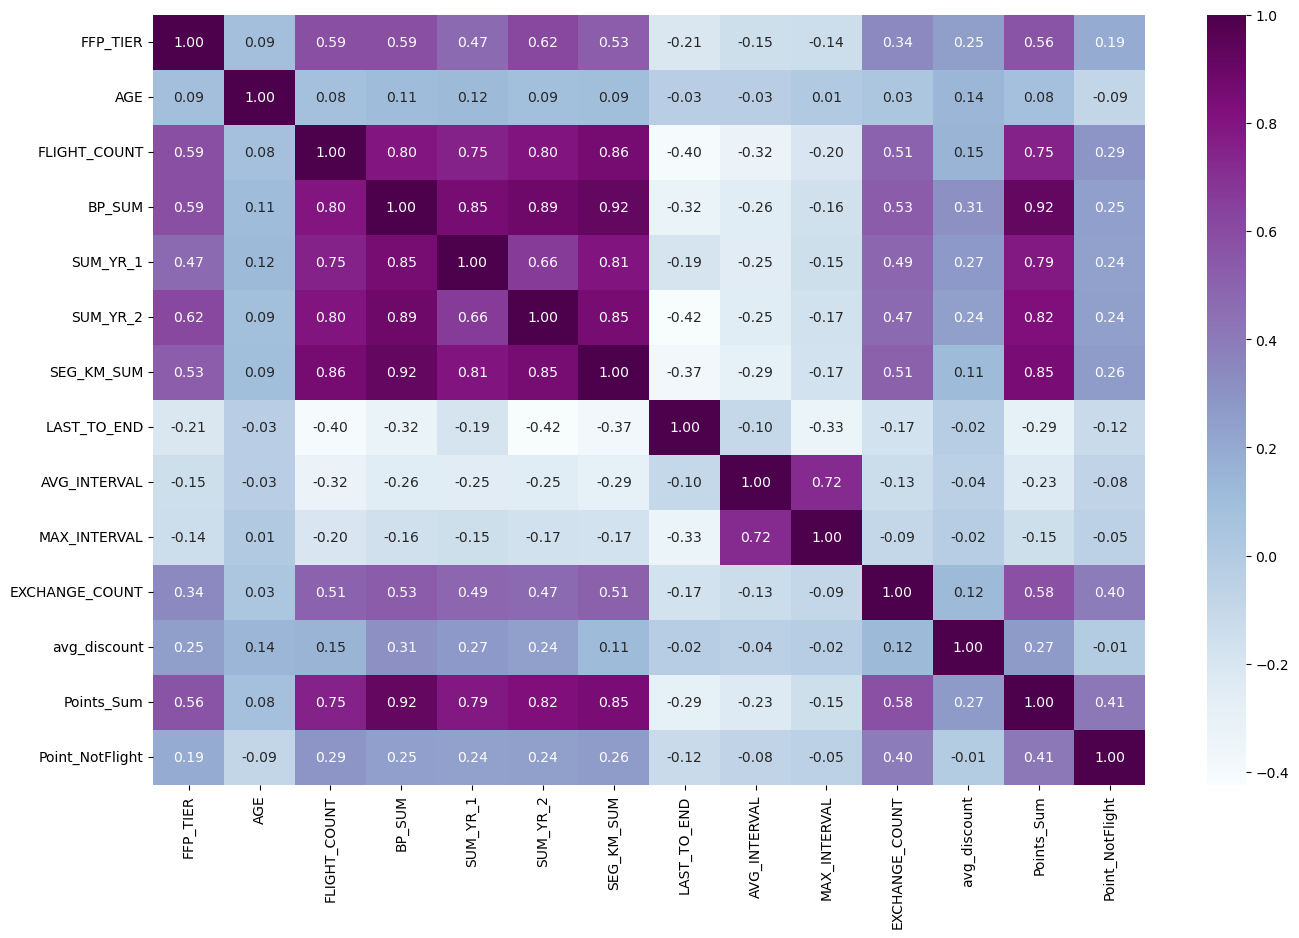

In [245]:
plt.figure(figsize=(16,10))
sns.heatmap(df_num.corr(), annot=True, fmt = ".2f", cmap = "BuPu")

## Data Transformation

The goal of this project is to divide airline customers into segments and to make business recommendation from the clustering model. The model itself will be built based on LRFMC anaylis that have been used in aviation industry to analyze customer value.

**LRFMC analysis will foucus on 5 aspects:**

L : The number of months since the member’s joining time from the end of the observation time. => LOAD_TIME - FFP_DATE (Length)

R : Number of months since the member’s last flight from the end of observation time. => LAST_TO_END (Recency)

F : The total number of times the member has flown during the observation period. => FLIGHT_COUNT (Frequency)

M : Miles accumulated during member observation time. => SEG_KM_SUM (Monetary)

C : The average value of the discount factor used by the member during the observation period. => avg_discount

In [246]:
df = df[df['SUM_YR_1'].notnull()]
df = df[df['SUM_YR_2'].notnull()]
 
index1 = df['SUM_YR_1'] != 0
index2 = df['SUM_YR_2'] != 0
index3 = (df['SEG_KM_SUM']==0) & (df['avg_discount']==0)
df = df[index1 | index2 | index3]

In [247]:
# Changing Load time and ffp date
df['LOAD_TIME'] = pd.to_datetime(df['LOAD_TIME'])
df['FFP_DATE'] = pd.to_datetime(df['FFP_DATE'])

In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58015 entries, 0 to 62978
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   FFP_DATE           58015 non-null  datetime64[ns]
 1   FIRST_FLIGHT_DATE  58015 non-null  object        
 2   GENDER             58015 non-null  object        
 3   FFP_TIER           58015 non-null  int64         
 4   WORK_CITY          58015 non-null  object        
 5   WORK_PROVINCE      58015 non-null  object        
 6   WORK_COUNTRY       58015 non-null  object        
 7   AGE                58015 non-null  float64       
 8   LOAD_TIME          58015 non-null  datetime64[ns]
 9   FLIGHT_COUNT       58015 non-null  int64         
 10  BP_SUM             58015 non-null  int64         
 11  SUM_YR_1           58015 non-null  float64       
 12  SUM_YR_2           58015 non-null  float64       
 13  SEG_KM_SUM         58015 non-null  int64         
 14  LAST_FLIGHT

In [249]:
# Create LRMFC Dataframe for further analysis
LRMFC = pd.DataFrame()

LRMFC['L'] =((df['LOAD_TIME'] - df['FFP_DATE']).dt.days/30)
LRMFC['R'] = df['LAST_TO_END']
LRMFC['F'] = df['FLIGHT_COUNT']
LRMFC['M'] = df['SEG_KM_SUM']
LRMFC['C'] = df['avg_discount']

LRMFC

,L,R,F,M,C
0,90.200000,1,210,580717,0.961639
2,87.166667,11,135,283712,1.254676
3,68.233333,97,23,281336,1.090870
4,60.533333,5,152,309928,0.970658
5,74.700000,79,92,294585,0.967692
...,...,...,...,...,...
62971,13.733333,360,2,1096,0.250000
62972,39.066667,180,2,1914,0.140000
62973,12.233333,357,2,760,0.350000
62976,45.400000,39,2,1062,0.225000


### Handling Outliers

In [250]:
features = list(LRMFC)

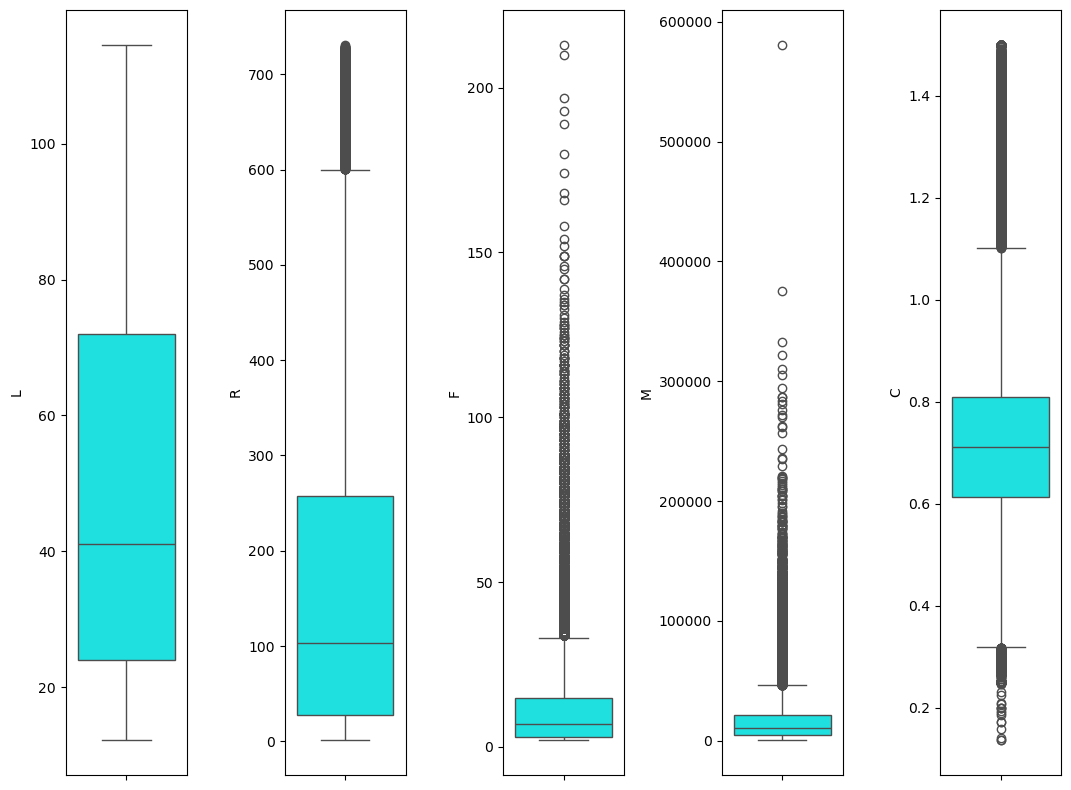

In [251]:
# Checking Outliers
plt.figure(figsize=(13, 8))
for i in range(0, len(features)):
    plt.subplot(1, 6, i+1)
    sns.boxplot(y=LRMFC[features[i]],color='cyan')
    plt.tight_layout()
plt.show()

In [252]:
# Log Transform
LRMFC['R'] = np.log1p(LRMFC['R'] + 1)
LRMFC['F'] = np.log1p(LRMFC['F'] + 1)
LRMFC['M'] = np.log1p(LRMFC['M'] + 1)
LRMFC['C'] = np.log1p(LRMFC['C'] + 1)

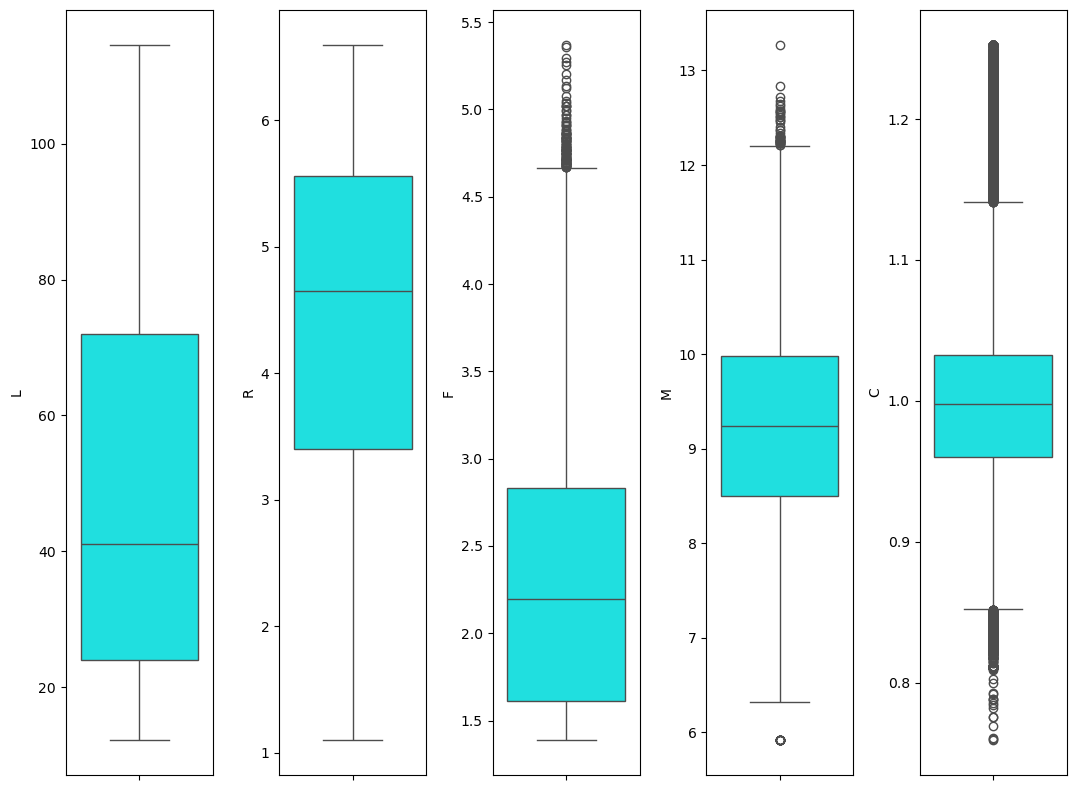

In [253]:
# Checking Outliers
plt.figure(figsize=(13, 8))
for i in range(0, len(features)):
    plt.subplot(1, 6, i+1)
    sns.boxplot(y=LRMFC[features[i]],color='cyan')
    plt.tight_layout()
plt.show()

It's better now, but thre's still some outliers

In [254]:
# Handling Outliers on F M C
Q1 = LRMFC['F'].quantile(0.25)
Q3 = LRMFC['F'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - (1.5 * IQR)
high_bound = Q3 + (1.5 * IQR)
New_F = ((LRMFC['F'] >= lower_bound) & (LRMFC['F'] <= high_bound))
LRMFC = LRMFC[New_F]

Q1 = LRMFC['M'].quantile(0.25)
Q3 = LRMFC['M'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - (1.5 * IQR)
high_bound = Q3 + (1.5 * IQR)
New_M = ((LRMFC['M'] >= lower_bound) & (LRMFC['M'] <= high_bound))
LRMFC = LRMFC[New_M]

Q1 = LRMFC['C'].quantile(0.25)
Q3 = LRMFC['C'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - (1.5 * IQR)
high_bound = Q3 + (1.5 * IQR)
New_C = ((LRMFC['C'] >= lower_bound) & (LRMFC['C'] <= high_bound))
LRMFC = LRMFC[New_C]



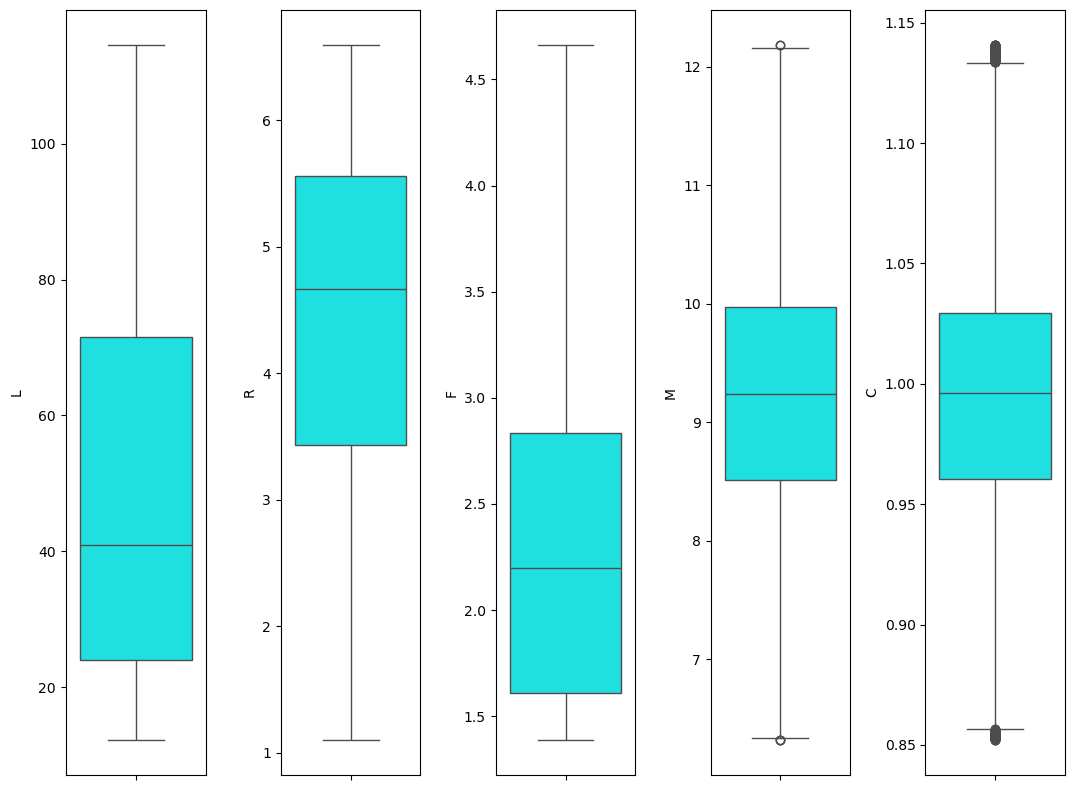

In [255]:
# Checking Outliers
plt.figure(figsize=(13, 8))
for i in range(0, len(features)):
    plt.subplot(1, 6, i+1)
    sns.boxplot(y=LRMFC[features[i]],color='cyan')
    plt.tight_layout()
plt.show()

Perfect!! Let's continue

### Data Scaling

In [256]:
stadardization = StandardScaler().fit_transform(LRMFC)
scaled_LRMFC = pd.DataFrame(stadardization, columns=list(LRMFC))
scaled_LRMFC.head()

,L,R,F,M,C
0,2.243689,-0.596662,1.271338,2.912456,2.524478
1,-0.077537,-1.666898,2.892023,2.896505,1.586048
2,-0.063194,-1.508119,1.552648,2.765714,2.339699
3,1.042437,0.055331,1.634783,2.873358,1.628684
4,-0.114590,-0.980188,1.712221,2.802495,2.067640


## Model training

### Find the best K

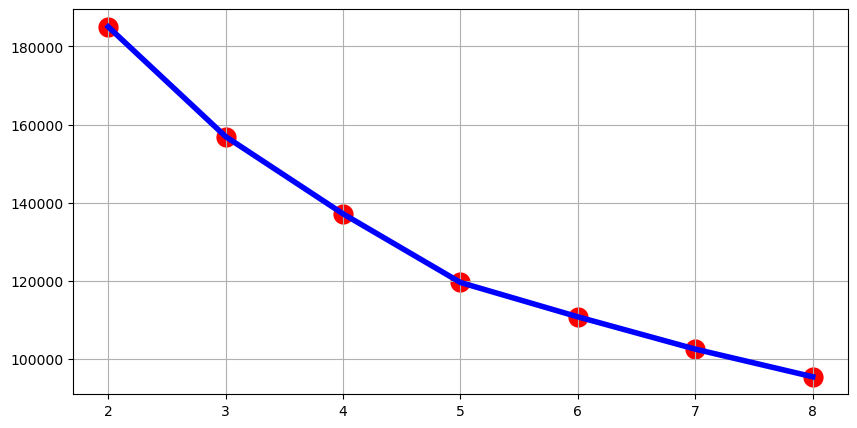

In [257]:
inertia = []
for i in range(2,9):
    kmeans = KMeans(n_clusters=i, random_state=24).fit(scaled_LRMFC)
    inertia.append(kmeans.inertia_)
    
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=range(2,9), y=inertia, color='blue', linewidth = 4)
sns.scatterplot(x=range(2,9), y=inertia, s=250, color='red')
ax.grid(True)

plt.show()


At a sight, we gonna say that 5 is the best K. But let's try another way

In [258]:
range_n_clusters = list(range(2,9))
print(range_n_clusters)

[2, 3, 4, 5, 6, 7, 8]


In [259]:
feats = list(scaled_LRMFC)
new_df = pd.DataFrame(data = scaled_LRMFC, columns = feats)
new_df.head()

,L,R,F,M,C
0,2.243689,-0.596662,1.271338,2.912456,2.524478
1,-0.077537,-1.666898,2.892023,2.896505,1.586048
2,-0.063194,-1.508119,1.552648,2.765714,2.339699
3,1.042437,0.055331,1.634783,2.873358,1.628684
4,-0.114590,-0.980188,1.712221,2.802495,2.067640


In [260]:
'''
arr_silhouette_score_euclidean = []
for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i).fit(scaled_LRMFC)
    preds = kmeans.predict(new_df)

    score_euclidean = silhouette_score(new_df, preds, metric='euclidean')
    arr_silhouette_score_euclidean.append(score_euclidean)'''

"\narr_silhouette_score_euclidean = []\nfor i in range_n_clusters:\n    kmeans = KMeans(n_clusters=i).fit(scaled_LRMFC)\n    preds = kmeans.predict(new_df)\n\n    score_euclidean = silhouette_score(new_df, preds, metric='euclidean')\n    arr_silhouette_score_euclidean.append(score_euclidean)"

In [261]:
'''fig, ax = plt.subplots(1,2,figsize=(15, 6))
sns.lineplot(x=range(2,9), y=arr_silhouette_score_euclidean, color='#000087', linewidth = 4, ax=ax[0])
sns.scatterplot(x=range(2,9), y=arr_silhouette_score_euclidean, s=300, color='#800000',  linestyle='--',ax=ax[0])

sns.lineplot(x=range(2, 9), y=inertia, color='#000087', linewidth = 4,ax=ax[1])
sns.scatterplot(x=range(2, 9), y=inertia, s=300, color='#800000',  linestyle='--', ax=ax[1])'''

"fig, ax = plt.subplots(1,2,figsize=(15, 6))\nsns.lineplot(x=range(2,9), y=arr_silhouette_score_euclidean, color='#000087', linewidth = 4, ax=ax[0])\nsns.scatterplot(x=range(2,9), y=arr_silhouette_score_euclidean, s=300, color='#800000',  linestyle='--',ax=ax[0])\n\nsns.lineplot(x=range(2, 9), y=inertia, color='#000087', linewidth = 4,ax=ax[1])\nsns.scatterplot(x=range(2, 9), y=inertia, s=300, color='#800000',  linestyle='--', ax=ax[1])"

K - andidate is 3, 4, 5

### 5 Cluster

In [262]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(scaled_LRMFC)

KMeans(n_clusters=5, random_state=42)

In [263]:
scaled_LRMFC['cluster'] = kmeans.labels_
LRMFC['cluster'] = kmeans.labels_

In [264]:
perc = [0.1,0.2,0.3,00.4,0.5,0.6,0.7,0.8,0.9]
LRMFC.describe(percentiles=perc)

,L,R,F,M,C,cluster
count,55378.000000,55378.000000,55378.000000,55378.000000,55378.000000,55378.000000
mean,48.528980,4.422049,2.319704,9.252789,0.994026,2.088880
std,27.887813,1.405382,0.738121,0.996081,0.052782,1.366063
min,12.166667,1.098612,1.386294,6.317165,0.851923,0.000000
10%,16.966667,2.302585,1.386294,7.938446,0.923476,0.000000
20%,21.600000,3.091042,1.609438,8.339023,0.950538,1.000000
30%,27.066667,3.688879,1.791759,8.665786,0.968761,1.000000
40%,33.266667,4.248495,1.945910,8.959954,0.983519,2.000000
50%,40.933333,4.663439,2.197225,9.240967,0.996206,2.000000
60%,51.533333,5.017280,2.397895,9.525589,1.008739,2.000000


In [265]:
LRMFC.groupby('cluster').agg({
                            'L' : ['median'],
                            'R' : ['median'],
                            'M' : ['mean'],
                            'F' : ["mean"],
                            'C' : ["mean"]

})

,L,R,M,F,C
,median,median,mean,mean,mean
cluster,,,,,
0,72.700000,2.772589,10.598103,3.452537,1.007461
1,29.233333,5.438079,8.543116,1.727035,0.929044
2,28.766667,3.891820,9.767794,2.658904,0.994497
3,82.666667,4.836282,9.083794,2.122466,0.994832
4,30.166667,5.631212,8.352075,1.719241,1.039789


ADA KEDEKATAN ANTARA CLUSTER 0 DAN 1 | 3 dan 4

In [266]:
pca = PCA(n_components=2)

pca.fit(scaled_LRMFC)
pcs = pca.transform(scaled_LRMFC)

data_pca = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2'])
data_pca['cluster'] = LRMFC['cluster'].values
data_pca.head()

,PC 1,PC 2,cluster
0,3.513824,-2.696597,0
1,4.464837,-2.108812,0
2,3.650659,-2.175759,0
3,3.354739,-1.715901,0
4,3.561987,-1.926256,0


<Axes: xlabel='PC 1', ylabel='PC 2'>

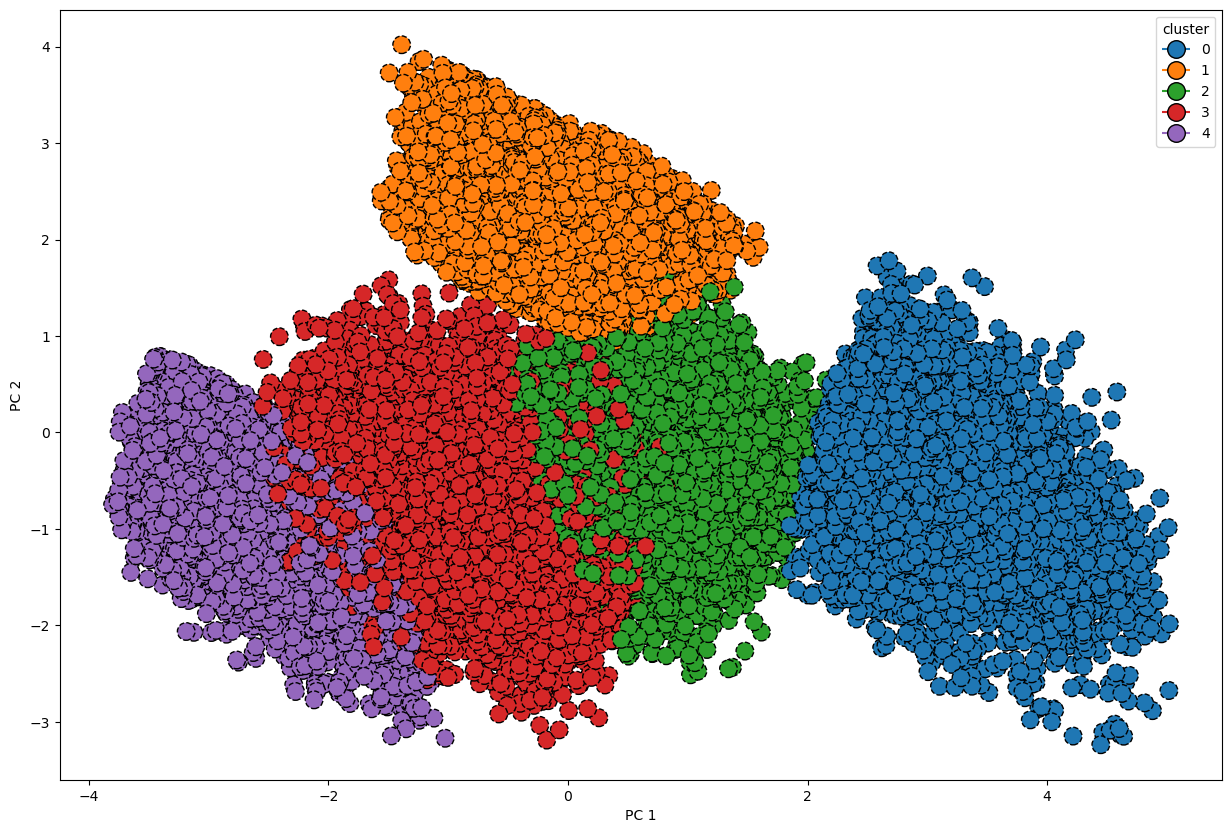

In [267]:
fig, ax = plt.subplots(figsize=(15,10))

sns.scatterplot(
    x="PC 1", y="PC 2",
    hue="cluster",
    edgecolor='black',
    linestyle='--',
    data=data_pca,
    palette=sns.color_palette("tab10"),
    s=160,
    ax=ax
)

TERDAPAT OVERLAP PADA 0 dan 1

### 4 Cluster

In [268]:
scaled_LRMFC = scaled_LRMFC.drop("cluster", axis=1)
LRMFC = LRMFC.drop("cluster", axis=1)

In [269]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_LRMFC)

KMeans(n_clusters=4, random_state=42)

In [270]:
scaled_LRMFC['cluster'] = kmeans.labels_
LRMFC['cluster'] = kmeans.labels_

In [271]:
perc = [0.1,0.2,0.3,00.4,0.5,0.6,0.7,0.8,0.9]
LRMFC.describe(percentiles=perc)

,L,R,F,M,C,cluster
count,55378.000000,55378.000000,55378.000000,55378.000000,55378.000000,55378.000000
mean,48.528980,4.422049,2.319704,9.252789,0.994026,1.525209
std,27.887813,1.405382,0.738121,0.996081,0.052782,1.030034
min,12.166667,1.098612,1.386294,6.317165,0.851923,0.000000
10%,16.966667,2.302585,1.386294,7.938446,0.923476,0.000000
20%,21.600000,3.091042,1.609438,8.339023,0.950538,1.000000
30%,27.066667,3.688879,1.791759,8.665786,0.968761,1.000000
40%,33.266667,4.248495,1.945910,8.959954,0.983519,1.000000
50%,40.933333,4.663439,2.197225,9.240967,0.996206,1.000000
60%,51.533333,5.017280,2.397895,9.525589,1.008739,2.000000


In [272]:
LRMFC.groupby('cluster').agg({
                            'L' : ['mean'],
                            'R' : ['median'],
                            'M' : ['mean'],
                            'F' : ["mean"],
                            'C' : ["mean"]

})

,L,R,M,F,C
,mean,median,mean,mean,mean
cluster,,,,,
0,68.626084,2.890372,10.543033,3.398449,1.006895
1,29.640382,5.659482,8.362909,1.672271,0.986645
2,31.165631,4.077537,9.665540,2.565918,0.991182
3,80.813672,5.017280,8.875030,1.992765,0.997142


In [273]:
pca = PCA(n_components=2)

pca.fit(scaled_LRMFC)
pcs = pca.transform(scaled_LRMFC)

data_pca = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2'])
data_pca['cluster'] = LRMFC['cluster'].values
data_pca.head()

,PC 1,PC 2,cluster
0,3.661084,1.365071,0
1,4.694349,-0.409103,0
2,3.823911,-0.357136,0
3,3.308268,0.313808,0
4,3.664774,-0.448888,0


<Axes: xlabel='PC 1', ylabel='PC 2'>

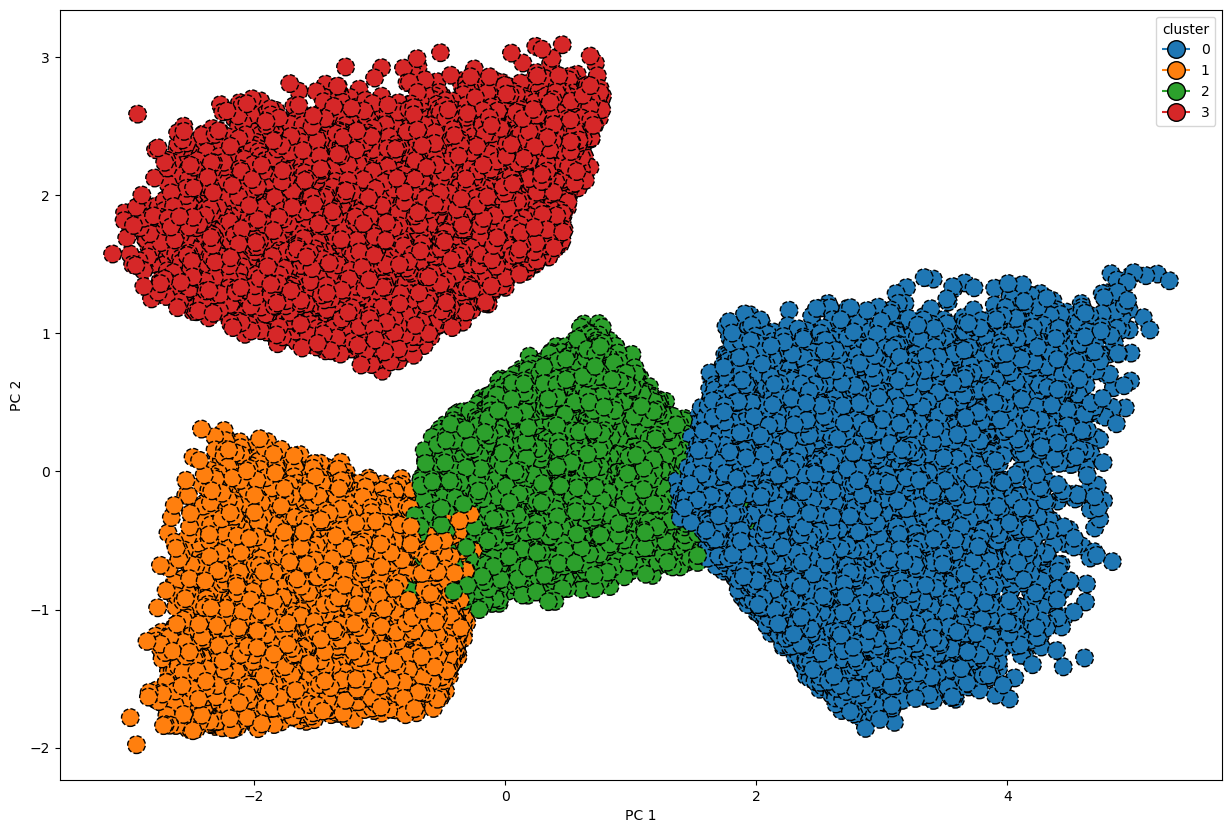

In [274]:
fig, ax = plt.subplots(figsize=(15,10))

sns.scatterplot(
    x="PC 1", y="PC 2",
    hue="cluster",
    edgecolor='black',
    linestyle='--',
    data=data_pca,
    palette=sns.color_palette("tab10"),
    s=160,
    ax=ax
)

GOOD ENOUGH! SMALL OVERLAP

## Cluster Visualization

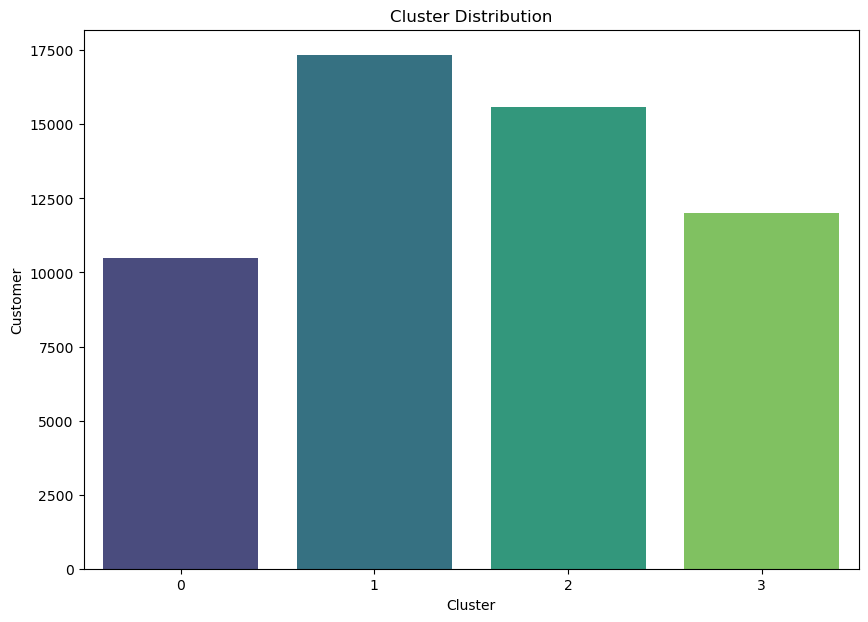

In [314]:
plt.figure(figsize=(10,7))
pl = sns.countplot(x = LRMFC['cluster'], palette='viridis')
pl.set_title('Cluster Distribution')
plt.xlabel("Cluster")
plt.ylabel("Customer")
plt.show()

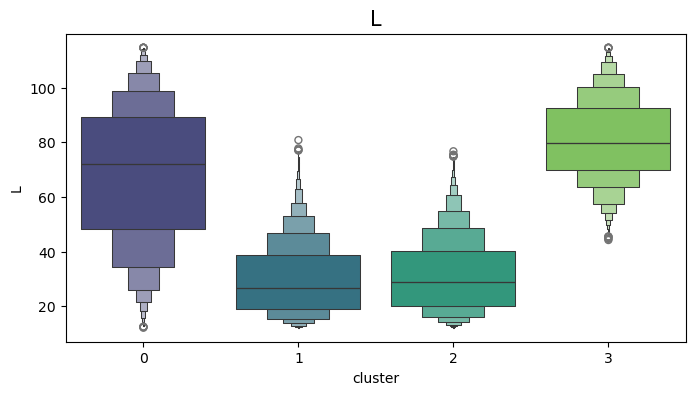

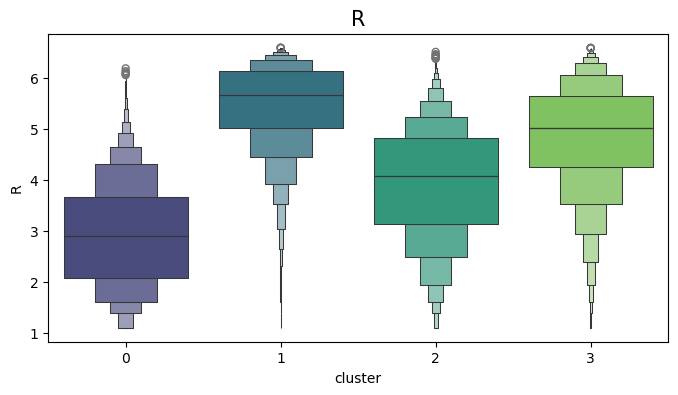

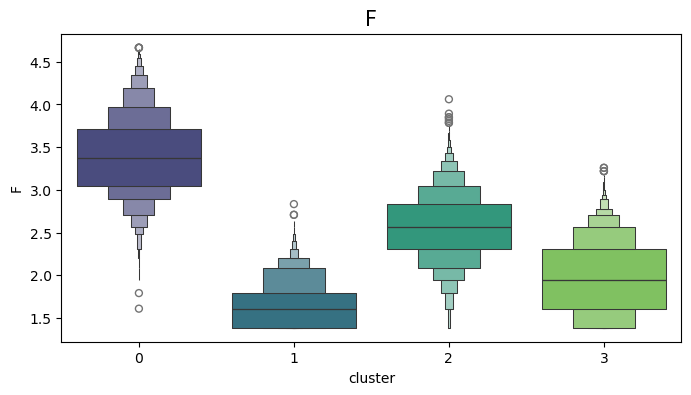

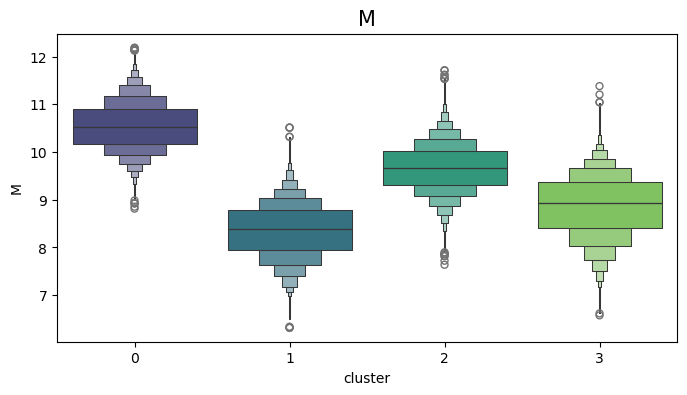

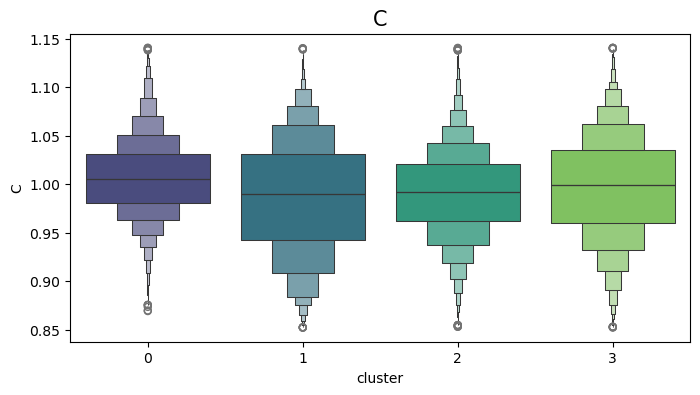

In [310]:
for i in LRMFC.columns[:-1]:
  plt.figure(figsize=(8,4))
  pl = sns.boxenplot(x = LRMFC['cluster'], y = LRMFC[i], palette='viridis')
  pl.set_title(i, fontsize=15)
plt.show()

In [315]:
pivot_LRMFC =  LRMFC.groupby('cluster').agg({'L': ['mean','median'],
                                                     'R': ['mean','median'],
                                                     'M': ['mean','median'],
                                                     'F': ['mean','median'],
                                                     'C': ['mean','median']}).reset_index()

In [316]:
pivot_LRMFC

cluster          L                    R                    M             \
                mean     median      mean    median       mean     median   
0       0  68.626084  71.866667  2.913369  2.890372  10.543033  10.530735   
1       1  29.640382  26.733333  5.475482  5.659482   8.362909   8.382747   
2       2  31.165631  28.766667  3.930628  4.077537   9.665540   9.658418   
3       3  80.813672  79.766667  4.856546  5.017280   8.875030   8.925720   

          F                   C            
       mean    median      mean    median  
0  3.398449  3.367296  1.006895  1.005774  
1  1.672271  1.609438  0.986645  0.990398  
2  2.565918  2.564949  0.991182  0.992418  
3  1.992765  1.945910  0.997142  0.998792